# WTTE-pipeline : data-munging template


Simple pipeline. Take by-timestamp records-data, aggregate over larger timeinterval (discretize) and reshape to tensor. 


# Example pipe

FLOW :
1. Munge df
    - want id,time to be unique
    - want to know start and end of sequence
    - want to have reasonable time-resolution (ex aggregate over days)
2. Padd with zeros for days between observations
3. Embed in fix-format tensor via rightpadding
4. Calculate censoring indicators and time to event
5. Train, Predict, Enjoy


### Meta-example: Tensorflow commit data

    cd tensorflow
    FILENAME="tensorflow.csv"

    echo commit,author_name,time_sec,subject,files_changed,lines_inserted,lines_deleted>../$FILENAME;

    git log --oneline --pretty="_Z_Z_Z_%h_Y_Y_\"%an\"_Y_Y_%at_Y_Y_\"%<(79,trunc)%f\"_Y_Y__X_X_"  --stat    \
        | grep -v \| \
        | sed -E 's/@//g' \
        | sed -E 's/_Z_Z_Z_/@/g' \
        |  tr "\n" " "   \
        |  tr "@" "\n" |sed -E 's/,//g'  \
        | sed -E 's/_Y_Y_/, /g' \
        | sed -E 's/(changed [0-9].*\+\))/,\1,/'  \
        | sed -E 's/(changed [0-9]* deleti.*-\)) /,,\1/' \
        | sed -E 's/insertion.*\+\)//g' \
        | sed -E 's/deletion.*\-\)//g' \
        | sed -E 's/,changed/,/' \
        | sed -E 's/files? ,/,/g'  \
        | sed -E 's/_X_X_ $/,,/g'  \
        | sed -E 's/_X_X_//g' \
        | sed -E 's/ +,/,/g' \
        | sed -E 's/, +/,/g'>>../$FILENAME;
        

For details about WTTE-RNN, check out

https://ragulpr.github.io/

https://github.com/ragulpr/wtte-rnn

https://github.com/ragulpr/wtte-rnn

http://wtte-rnn.readthedocs.io/en/develop/

Written by Egil Martinsson

MIT license

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import wtte.tte_util as tte
import wtte.transforms as tr

from wtte.pipelines import data_pipeline
from wtte.plots.misc import timeline_aggregate_plot,timeline_plot

pd.options.display.max_rows = 10
from IPython import display

Skipping line 1271: expected 7 fields, saw 9
Skipping line 2837: expected 7 fields, saw 9



['commit' 'author_name' 'time_sec' 'subject' 'files_changed'
 'lines_inserted' 'lines_deleted']


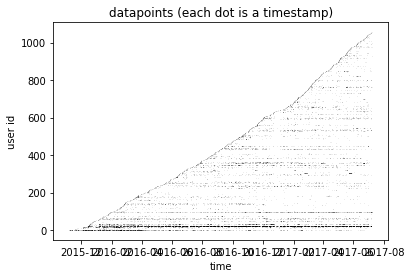

,commit,author_name,time_int,subject,files_changed,lines_inserted,lines_deleted,id,n_commits
19519,f41959c,Manjunath Kudlur,1446856078,TensorFlow-Initial-commit-of-TensorFlow-librar...,1900.0,391534.0,0.0,1,1
19518,cd9e60c,Manjunath Kudlur,1446863831,TensorFlow-Upstream-latest-changes-to-Git ...,72.0,1289.0,958.0,1,1
19512,71842da,Manjunath Kudlur,1447019816,TensorFlow-Upstream-latest-changes-to-git ...,14.0,110.0,110.0,1,1
19511,1d3874f,Manjunath Kudlur,1447024477,TensorFlow-Upstream-changes-to-git ...,22.0,430.0,405.0,1,1
19510,b2dc60e,Manjunath Kudlur,1447033308,TensorFlow-Upstream-changes-to-git ...,34.0,398.0,314.0,1,1
...,...,...,...,...,...,...,...,...,...
78,8dd5441,yorkie,1499333595,c-fix-a-possible-segmentfault ...,1.0,2.0,0.0,1051,1
58,de2a2df,Igor Saprykin,1499357415,Fix-the-broken-image-in-the-tf-extend-estimato...,1.0,2.0,2.0,1052,1
29,9f57dc8,Bruno Rosa,1499375201,Use-mcpu-instead-of-march-for-ppc64le ...,1.0,10.0,1.0,1053,1
10,764c9b6,Louis Tiao,1499401060,Fixed-typo-in-docstring ...,1.0,1.0,1.0,1054,1


In [2]:

path = "~/Prylar/clones/logs/"
# filename = "amazon-dsstne.csv"
# filename = "caffe.csv"
# filename = "CNTK.csv"
# filename = "convnetjs.csv"
# filename = "deeplearning4j.csv"
# filename = "h2o-3.csv"
# filename = "incubator-singa.csv"
# filename = "keras.csv"
# filename = "mxnet.csv"
# filename = "Paddle.csv"
# filename = "Theano.csv"
# filename = "torch7.csv"
# filename = "veles.csv"
# filename = "linux.csv"
filename = "tensorflow.csv"

df = pd.read_csv(path+filename,error_bad_lines=False,low_memory=False)

print(df.columns.values)
df.fillna(0,inplace=True)

df.rename(columns={"time_sec": "time_int"},inplace=True)
## For transformation df->tensor
id_col='id'
abs_time_col='time_int'
# Put the column indicating 'events' first!
feature_cols= ["n_commits",'files_changed','lines_inserted','lines_deleted']
# feature_cols= ["n_commits"]
constant_cols = []
mean_cols = []

infer_seq_endtime=True
time_sec_interval=60*60*24
timestep_aggregation_dict=dict.fromkeys(feature_cols, "sum")
drop_last_timestep=True


## Create a new sequence-key based on time of first event.
df[id_col] = df.groupby(['author_name'], group_keys=False).\
               apply(lambda g: g.time_int.min().\
               astype(str)+g.author_name.astype(str)).\
               rank(method='dense').astype(int)

df.sort_values([id_col,'time_int'],inplace=True)

df['n_commits'] = 1

plt.scatter(x=pd.to_datetime(df.time_int.values,unit='s'),
            y=df.id,s=0.05, linewidth='0',color='black')
plt.title('datapoints (each dot is a timestamp)')
plt.xlabel('time')
plt.ylabel('user id')
plt.show()

df


In [3]:
import re
# Aggregates by timestep using sum by default. 
# `constant_cols` and `mean_cols` are aggregated using mean
timestep_aggregation_dict = dict.fromkeys(feature_cols, "sum")
for key in timestep_aggregation_dict:
    for query in list(set().union(constant_cols,mean_cols)):
        if re.match(query+'($|_)', key): # binary cols are formatted as `col_level`
            timestep_aggregation_dict[key] = 'mean'
print('how features will be aggregated each day:')
print(timestep_aggregation_dict)

how features will be aggregated each day:
{'files_changed': 'sum', 'n_commits': 'sum', 'lines_deleted': 'sum', 'lines_inserted': 'sum'}


## Dataframe to tensor

    1. Lower the resolution of the (int) `abs_time_col` ex from epoch sec to epoch day by aggregating\
      each column using `timestep_aggregation_dict`.

    2. Padds out with zeros between timesteps and fills with value of `constant_cols`.

    3. Infers where the last 'non-event' was, i.e the day that we made the query. This is the time of censoring.

If you think this is too much magic, look out for the next example notebook which will break up the steps.

In [4]:
discrete_time=True
pad_between_steps=True

x, padded_t, seq_ids, df_tmp = \
    data_pipeline(df,
                  id_col=id_col,
                  abs_time_col=abs_time_col,
                  column_names=feature_cols,
                  constant_cols = constant_cols,
                  discrete_time=discrete_time,
                  pad_between_steps=pad_between_steps,
                  infer_seq_endtime=infer_seq_endtime,
                  time_sec_interval=time_sec_interval,
                  timestep_aggregation_dict=timestep_aggregation_dict,
                  drop_last_timestep=drop_last_timestep
                  )
print(x.shape)
df_tmp


(1055, 609, 4)


,id,time_int,files_changed,n_commits,lines_deleted,lines_inserted,t_elapsed
0,1,1446854400,1972.0,2.0,958.0,392823.0,0
1,1,1446940800,36.0,2.0,515.0,540.0,1
2,1,1447027200,68.0,7.0,1755.0,1888.0,2
3,1,1447977600,1271.0,1.0,1067.0,18402.0,13
4,1,1448409600,322.0,3.0,2888.0,5183.0,18
...,...,...,...,...,...,...,...
9100,1052,1499385600,0.0,0.0,0.0,0.0,1
9101,1053,1499299200,1.0,1.0,1.0,10.0,0
9102,1053,1499385600,0.0,0.0,0.0,0.0,1
9103,1054,1499385600,1.0,1.0,1.0,1.0,0


### The first feature in `x` is the event-indicator

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


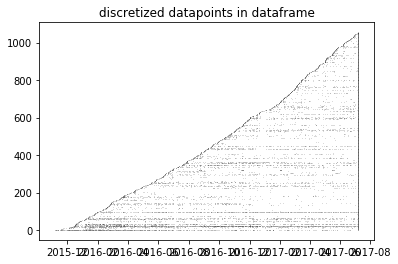

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


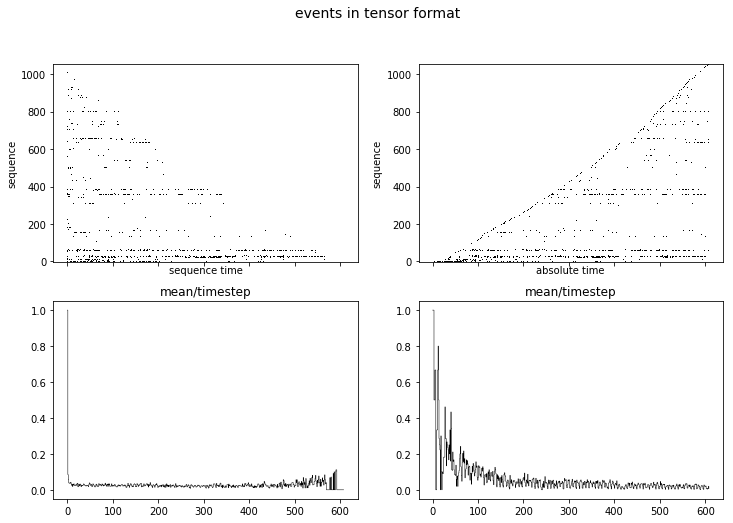

In [5]:
# We assume the first column is the event-indicator:
events = (np.copy(x[:,:,0])>0).astype(float)
events[np.isnan(x[:,:,0])] = np.nan

assert(np.nansum(df_tmp.n_commits.values>0)==np.nansum(events))

plt.scatter(
              x=pd.to_datetime(df_tmp['time_int'],unit='s').values,
              y=df_tmp['id'].values,
              s=.1,
              linewidth='0', 
              color='black')
plt.title('discretized datapoints in dataframe')
plt.show()

timeline_aggregate_plot(events,"events in tensor format",cmap="Greys")
plt.show()


### Example of tensor-feature engineering - global features

- Simply add the mean events per day time series to every timestep where it was known in realtime.

In [6]:
# Add a global feature "mean (number of events) today"
add_global_feature = True
if add_global_feature:
    padded = tr.right_pad_to_left_pad(x[:,:,0])
    x_global = np.nanmean(padded,0)
    x_global = np.expand_dims(x_global,0)
    x_global = padded*0+x_global

    x_global =  tr.left_pad_to_right_pad(x_global)
    x = np.concatenate([x,np.expand_dims(x_global,-1)],-1)
    
    feature_cols.append('mean_commits_global')
    del padded,x_global
    

## Format tensor for training
* calculate tte-values
* Split into train/test. Some alternatives:
* **Hide the truth from the model** (disalign features and target). 
    - Think *'todays prediction about today and tomorrow is what happened yesterday'*
* normalize (using training data)

In [7]:
def drop_n_last_timesteps(padded,n_timesteps_to_drop,remove_empty_seqs = True):
    # brutal method: simply right align all tensors and simply cut off the last n_timesteps_to_drop
    n_timesteps = x.shape[1]
    padded      = tr.left_pad_to_right_pad(tr.right_pad_to_left_pad(padded)[:,:(n_timesteps-n_timesteps_to_drop)])
    
    if remove_empty_seqs:
        seq_lengths = tr.get_padded_seq_lengths(padded)
        padded = padded[seq_lengths>0]
    return padded
    
def prep_tensors(x,events):
    # 0. calculate time to event and censoring indicators.
    y  = np.ones([events.shape[0],events.shape[1],2])
    y[:,:,0] = tr.padded_events_to_tte(np.squeeze(events),discrete_time=True)
    y[:,:,1] = tr.padded_events_to_not_censored(np.squeeze(events),discrete_time=True)

    # 1. Disalign features and targets otherwise truth is leaked.
    # 2. drop first timestep (that we now dont have features for)
    # 3. nan-mask the last timestep of features. (that we now don't have targets for)
    events = events[:,1:,]
    y  = y[:,1:]
    x  = np.roll(x, shift=1, axis=1)[:,1:,]
    x  = x + 0*np.expand_dims(events,-1)
    return x,y,events

n_timesteps = x.shape[1]
n_features = x.shape[2]

## Hide 30% of the last timesteps and keep them for testing
frac_timesteps_to_cut = 0.10
n_testing_timesteps = np.floor(n_timesteps*frac_timesteps_to_cut).astype(int)

x_train      = drop_n_last_timesteps(x,n_testing_timesteps)
events_train = drop_n_last_timesteps(events,n_testing_timesteps)

# Do the necessary preparations of the tensors.
x_train,y_train,events_train = prep_tensors(x_train,events_train)
x,y,events    = prep_tensors(x,events)

# Normalize
x_train, means, stds = tr.normalize_padded(x_train,means=None,stds=None)
x, means, stds = tr.normalize_padded(x,means=means,stds=stds)

seq_lengths = np.count_nonzero(~np.isnan(events), axis=1)
seq_lengths_train = np.count_nonzero(~np.isnan(events_train), axis=1)

# Used for initialization of alpha-bias:
tte_mean_train = np.nanmean(y_train[:,:,0])
mean_u = np.nanmean(y_train[:,:,1])

print('events',events.shape,events.dtype)
print('x min max ',np.nanmin(x),np.nanmax(x))
print('x',x.shape,x.dtype)
print('y',y.shape,y.dtype)
print('x_train',x_train.shape,x_train.dtype)
print('y_train',y_train.shape,y_train.dtype)
print('tte_mean_train: ', tte_mean_train)
print('mean uncensored train: ', np.nanmean(y_train[:,:,1]))

print('x_train size',x_train.nbytes*1e-6,' mb')

events (1055, 608) float64
x min max  -0.98018301524 459.789661149
x (1055, 608, 5) float64
y (1055, 608, 2) float64
x_train (924, 548, 5) float64
y_train (924, 548, 2) float64
tte_mean_train:  129.476914792
mean uncensored train:  0.23123676255
x_train size 20.25408  mb


## Visualize tensor data

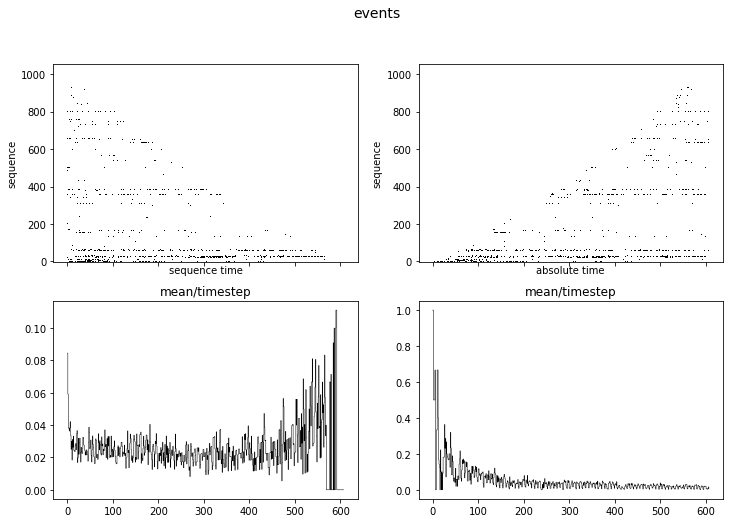

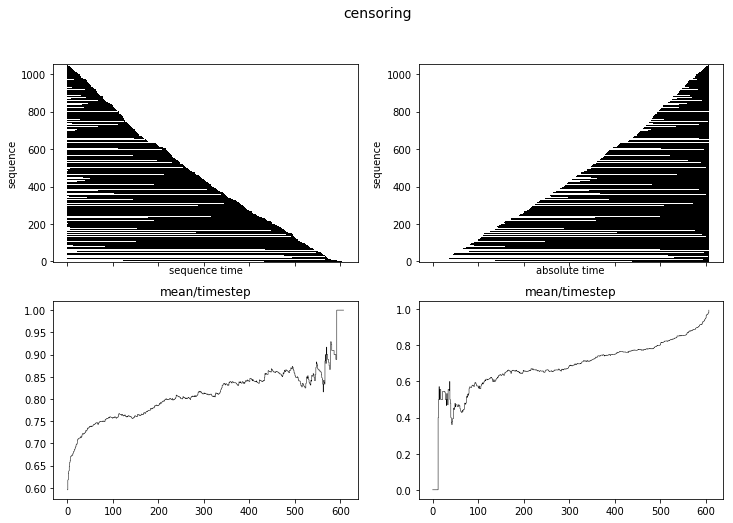

############## TRAINING SET


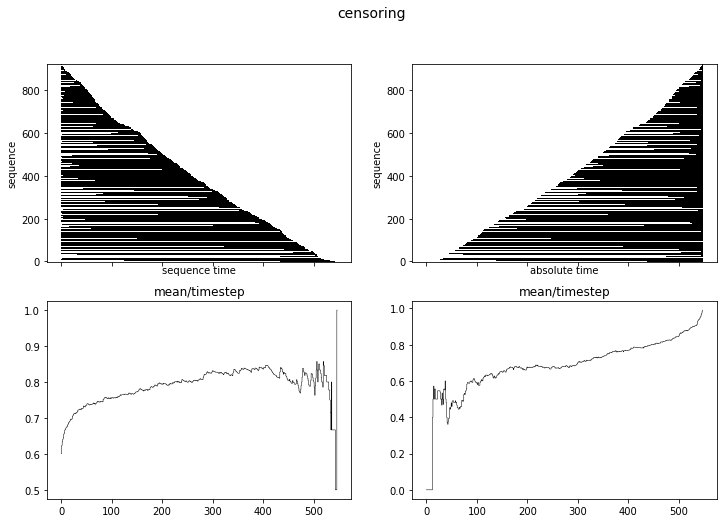

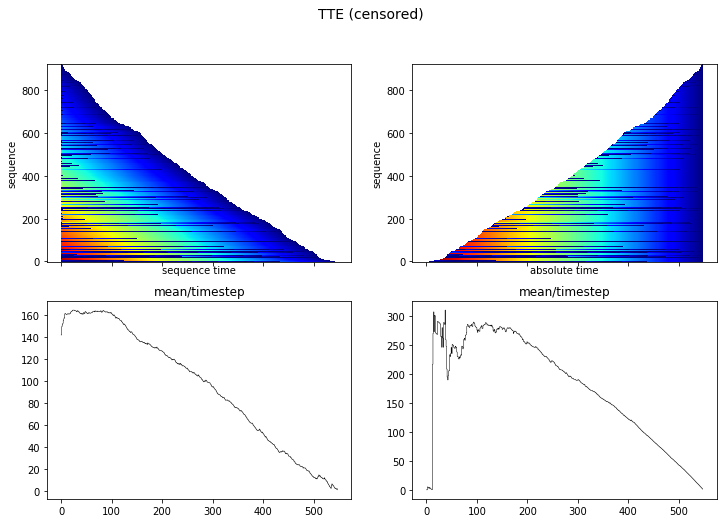

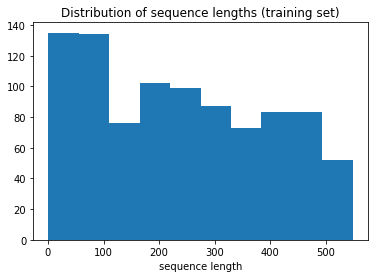

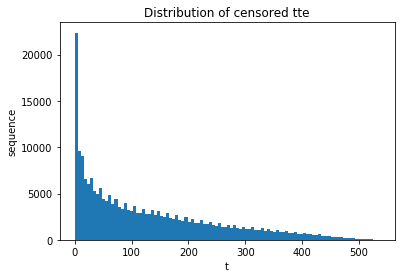

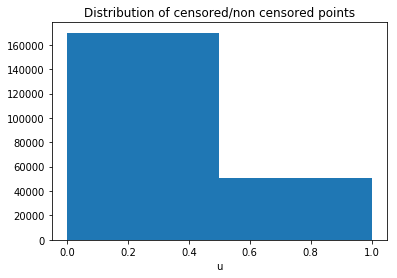

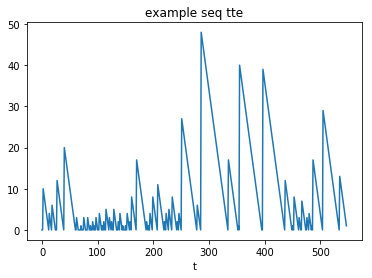

########## features


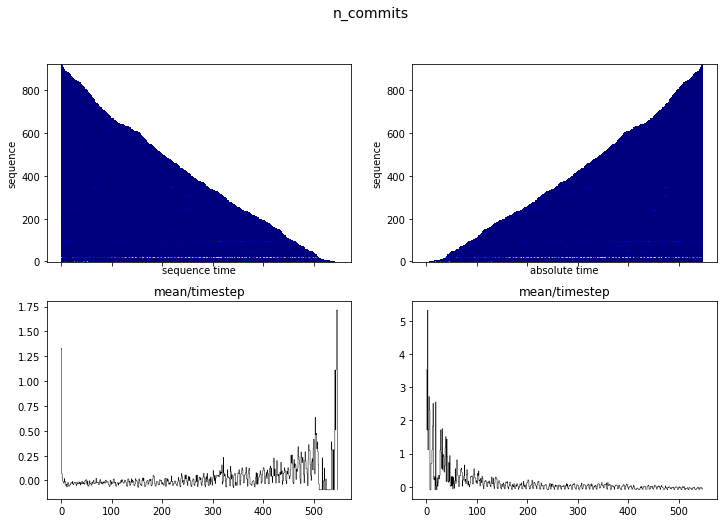

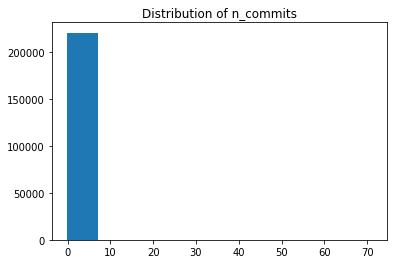

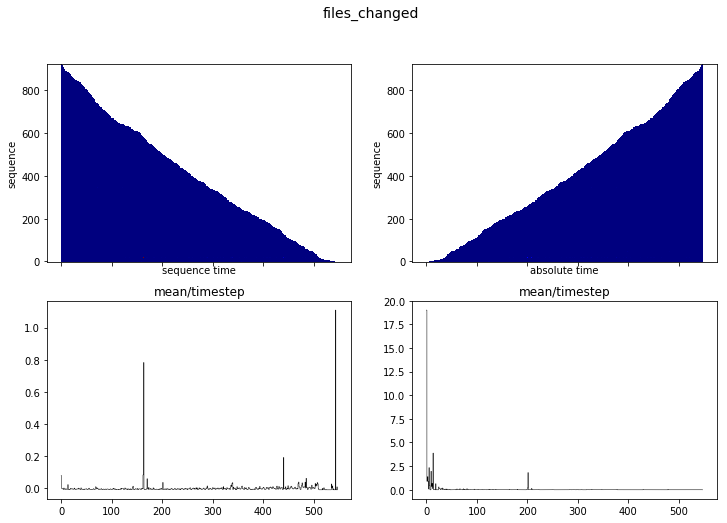

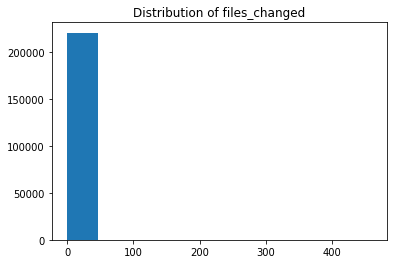

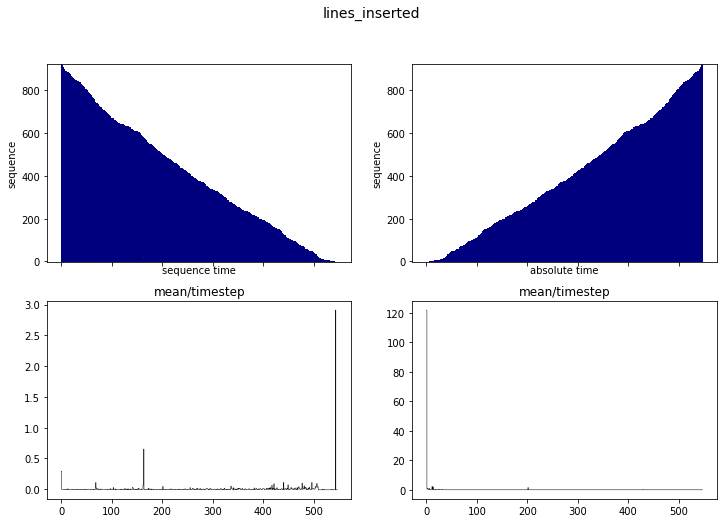

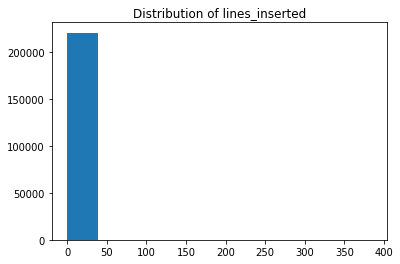

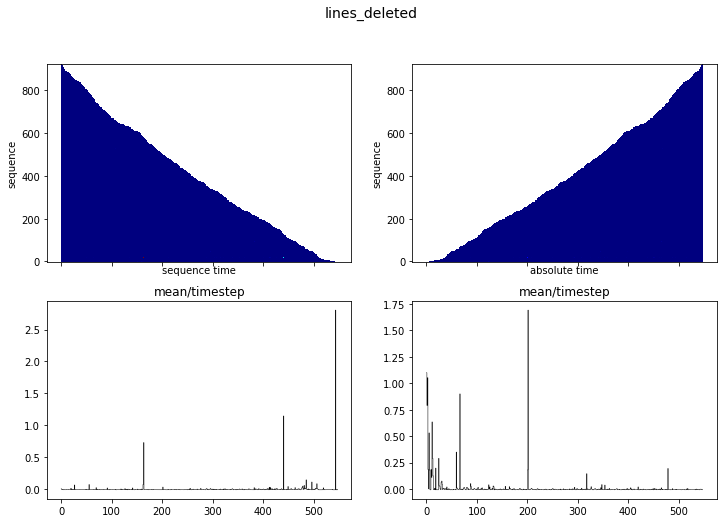

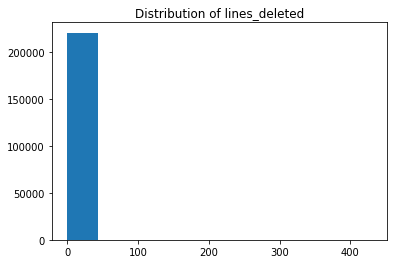

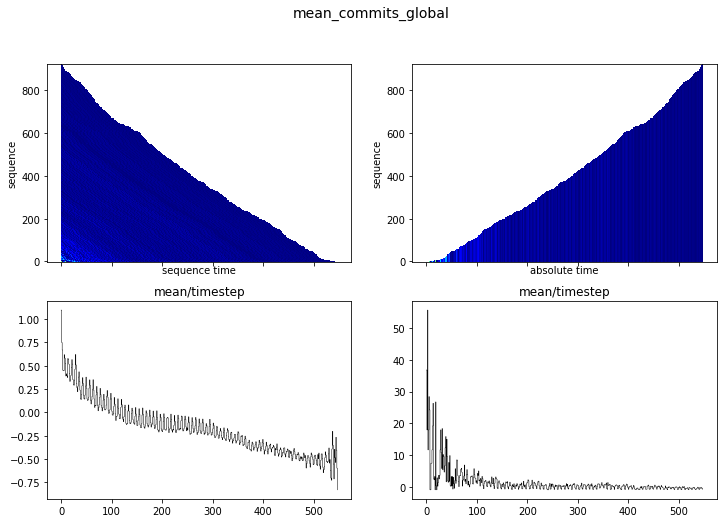

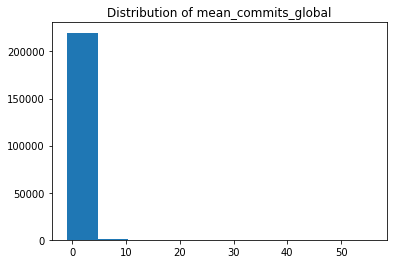

########## 


In [8]:
# def timeline_plot(padded,title='',cmap=None,plot=True,fig=None,ax=None):
#     if fig is None or ax is None:
#         fig, ax = plt.subplots(ncols=2, sharey=True,figsize=(12,4))
    
#     ax[0].imshow(padded,interpolation='none', aspect='auto',cmap=cmap,origin='lower')    
#     ax[0].set_ylabel('sequence');
#     ax[0].set_xlabel('sequence time');
        
#     im = ax[1].imshow(tr.right_pad_to_left_pad(padded),interpolation='none', aspect='auto',cmap=cmap,origin='lower')  
#     ax[1].set_ylabel('sequence');
#     ax[1].set_xlabel('absolute time'); #(Assuming sequences end today)
    
#     fig.suptitle(title,fontsize=14)
#     if plot:
#         fig.show()
#         return None,None
#     else:
#         return fig,ax

# def timeline_aggregate_plot(padded,title='',cmap=None,plot=True):
#     fig, ax = plt.subplots(ncols=2,nrows=2,sharex=True, sharey=False,figsize=(12,8))
    
#     fig,ax[0] = timeline_plot(padded,title,cmap=cmap,plot=False,fig=fig,ax=ax[0])
    
#     ax[1,0].plot(np.nanmean(padded,axis=0),lw=0.5,c='black',drawstyle='steps-post')
#     ax[1,0].set_title('mean/timestep')
#     padded = tr.right_pad_to_left_pad(padded)
#     ax[1,1].plot(np.nanmean(padded,axis=0),lw=0.5,c='black',drawstyle='steps-post')
#     ax[1,1].set_title('mean/timestep')

#     fig.suptitle(title,fontsize=14)
#     if plot:
#         fig.show()
#         return None,None
#     else:
#         return fig,ax
    
timeline_aggregate_plot(events,"events",cmap="Greys")
plt.show()

timeline_aggregate_plot(1-y[:,:,1],"censoring",cmap="Greys")
plt.show()

print('############## TRAINING SET')
######
timeline_aggregate_plot(1-y_train[:,:,1],'censoring',cmap='Greys')
plt.show()
timeline_aggregate_plot(y_train[:,:,0],'TTE (censored)',cmap='jet')
plt.show()

train_mask = (False==np.isnan(y_train[:,:,0]))

plt.hist(seq_lengths_train)
plt.title('Distribution of sequence lengths (training set)')
plt.xlabel('sequence length')
plt.show()

plt.hist(y_train[:,:,0][train_mask].flatten(),100)
plt.title('Distribution of censored tte')
plt.ylabel('sequence')
plt.xlabel('t')
plt.show()

plt.hist(y_train[:,:,1][train_mask].flatten(),2)
plt.title('Distribution of censored/non censored points')
plt.xlabel("u")
plt.show()

plt.plot(y_train[0,:,0])
plt.title('example seq tte')
plt.xlabel('t')
plt.show()

print('########## features')
for f in xrange(x_train.shape[2]):
    try:
        feature_name = feature_cols[f]
    except:
        feature_name = '???'
        
    timeline_aggregate_plot(x_train[:,:,f],feature_name,cmap = 'jet')
    plt.show()
    tmp = x_train[:,:,f].flatten()
    plt.hist(tmp[False==np.isnan(tmp)],10)
    plt.title('Distribution of '+feature_name)
    plt.show()
print('########## ')
del tmp,train_mask


## Masks, weights and validation set

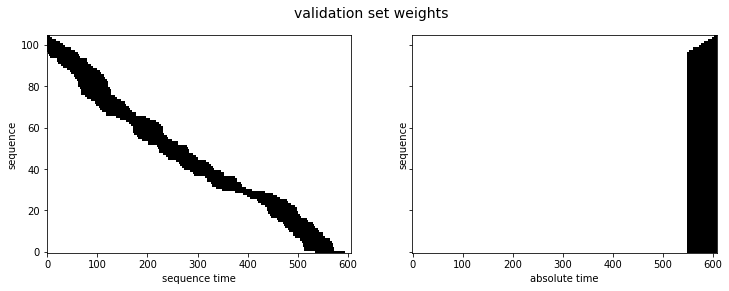

init_alpha:  562.091737561 mean uncensored train:  0.23123676255


In [9]:
def nanmask_to_keras_mask(x,y,mask_value,tte_mask):
    """nanmask to keras mask.
        :param float mask_value: Use some improbable telltale value 
                                (but not nan-causing)
        :param float tte_mask: something that wont NaN the loss-function
    """
    # Use some improbable telltale value (but not nan-causing)
    x[:,:,:][np.isnan(x)] = mask_value
    y[:,:,0][np.isnan(y[:,:,0])] = tte_mask
    y[:,:,1][np.isnan(y[:,:,1])] = 0.5
    sample_weights = (x[:,:,0]!=mask_value)*1.
    return x,y,sample_weights

mask_value = -1.3371337 

x_train,y_train,sample_weights_train = nanmask_to_keras_mask(x_train,y_train,mask_value,tte_mean_train)

# Pick 10% of the sequences beyond the boundary for validation
valid_indx = np.where(np.random.sample(len(y))<0.1)
x_valid = x[valid_indx].copy()
y_valid = y[valid_indx].copy()
padded = np.copy(y_valid[:,:,0])

x_valid,y_valid,sample_weights_valid = nanmask_to_keras_mask(x_valid,y_valid,mask_value,tte_mean_train)

# Set weights to 0s except the non-nan last timesteps not in training
n_timesteps_to_hide = x_valid.shape[1]-x_train.shape[1]
padded[~np.isnan(padded)] = 1.
padded = tr.right_pad_to_left_pad(padded)
padded[:,:-n_timesteps_to_hide] = padded[:,:-n_timesteps_to_hide]*0
padded = tr.left_pad_to_right_pad(padded)
timeline_plot(padded,'validation set weights','Greys')

padded[np.isnan(padded)] = 0
sample_weights_valid = np.copy(padded)
plt.show()
del padded,valid_indx



# Initialization value for alpha-bias 
init_alpha = -1.0/np.log(1.0-1.0/(tte_mean_train+1.0) )
init_alpha = init_alpha/mean_u
print('init_alpha: ',init_alpha,'mean uncensored train: ',mean_u)


In [10]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import wtte.tte_util as tte
import wtte.transforms as tr

from wtte.pipelines import data_pipeline
import wtte.tte_util as tte
import wtte.weibull as weibull
import wtte.wtte as wtte
from wtte.wtte import WeightWatcher

pd.options.display.max_rows = 20
from IPython import display

import keras.backend as K
from keras.models import Sequential

from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Masking
from keras.layers import Lambda
from keras.layers.wrappers import TimeDistributed
from keras.layers.normalization import BatchNormalization

from keras import regularizers
from keras import callbacks
from keras.optimizers import RMSprop,adam
from keras.models import load_model

import wtte.weibull as weibull
import wtte.wtte as wtte
from wtte.wtte import WeightWatcher

Using Theano backend.


In [11]:
# from phased_lstm_keras.PhasedLSTM import PhasedLSTM as PLSTM

np.random.seed(1)
K.set_epsilon(1e-8)

## Callbacks
checkpointer = callbacks.ModelCheckpoint('./model_checkpoint.h5', 
                          monitor='loss', 
                          verbose=1, 
                          save_best_only=True, 
                          save_weights_only=True, 
                          mode='auto', period=5)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', 
                                        factor  =0.5, 
                                        patience=15, 
                                        verbose=1, 
                                        mode='auto', 
                                        epsilon=0.0001, 
                                        cooldown=0, 
                                        min_lr=1e-8)

nanterminator = callbacks.TerminateOnNaN()
history = callbacks.History()
weightwatcher = WeightWatcher(per_batch =False,per_epoch= True)
n_features = x_train.shape[-1]

## Base model
model = Sequential()
model.add(Masking(mask_value=mask_value,input_shape=(None, n_features)))
model.add(GRU(10,activation='tanh',return_sequences=True,recurrent_dropout=0.1,unroll=False))
model.add(BatchNormalization(axis=-1, momentum=0.9, epsilon=0.01))

model.add(TimeDistributed(Dense(10,activation='tanh')))

## Wtte-RNN part
model.add(TimeDistributed(Dense(2)))
model.add(Lambda(wtte.output_lambda, arguments={"init_alpha":init_alpha, 
                                                "max_beta_value":2.0,
                                                "alpha_kernel_scalefactor":0.5
                                               }))

loss = wtte.loss(kind='discrete',reduce_loss=False).loss_function
model.compile(loss=loss, optimizer=adam(lr=.01,clipvalue=0.5),sample_weight_mode='temporal')
model.summary()


/usr/local/lib/python2.7/site-packages/keras/layers/core.py:633: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, None, 2)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, None, 5)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, None, 10)          480       
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 10)          40        
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 10)          110       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 2)           22        
_________________________________________________________________
lambda_1 (Lambda)            (None, None, 2)           0         
Total params: 652
Trainable params: 632
Non-trainable params: 20
_________________________________________________________________


In [12]:
K.set_value(model.optimizer.lr, 0.01)
model.fit(x_train, y_train,
          epochs=300,
          batch_size=300, 
          verbose=1,
          validation_data=(x_valid, y_valid,sample_weights_valid),
          sample_weight = sample_weights_train,
          callbacks=[nanterminator,history,weightwatcher,reduce_lr])



Train on 924 samples, validate on 105 samples
Epoch 1/300
924/924 [==============================] - 2s - loss: 1.6050 - val_loss: 0.4492
Epoch 2/300
924/924 [==============================] - 2s - loss: 1.5074 - val_loss: 0.4355
Epoch 3/300
924/924 [==============================] - 2s - loss: 1.4747 - val_loss: 0.4303
Epoch 4/300
924/924 [==============================] - 3s - loss: 1.4781 - val_loss: 0.4303
Epoch 5/300
924/924 [==============================] - 2s - loss: 1.4602 - val_loss: 0.4337
Epoch 6/300
924/924 [==============================] - 2s - loss: 1.4538 - val_loss: 0.4390
Epoch 7/300
924/924 [==============================] - 2s - loss: 1.4429 - val_loss: 0.4373
Epoch 8/300
924/924 [==============================] - 2s - loss: 1.4315 - val_loss: 0.4425
Epoch 9/300
924/924 [==============================] - 2s - loss: 1.4165 - val_loss: 0.4123
Epoch 10/300
924/924 [==============================] - 2s - loss: 1.4037 - val_loss: 0.3812
Epoch 11/300
924/924 [===========

924/924 [==============================] - 4s - loss: 1.2745 - val_loss: 0.3719
Epoch 173/300
924/924 [==============================] - 5s - loss: 1.2587 - val_loss: 0.3738
Epoch 174/300
924/924 [==============================] - 3s - loss: 1.2638 - val_loss: 0.3649
Epoch 175/300
924/924 [==============================] - 3s - loss: 1.2664 - val_loss: 0.3580
Epoch 176/300
924/924 [==============================] - 3s - loss: 1.2691 - val_loss: 0.3588
Epoch 177/300
924/924 [==============================] - 3s - loss: 1.2556 - val_loss: 0.3576
Epoch 178/300
924/924 [==============================] - 3s - loss: 1.2577 - val_loss: 0.3573
Epoch 179/300
924/924 [==============================] - 3s - loss: 1.2663 - val_loss: 0.3584
Epoch 180/300
924/924 [==============================] - 4s - loss: 1.2559 - val_loss: 0.3614
Epoch 181/300
924/924 [==============================] - 3s - loss: 1.2577 - val_loss: 0.3658
Epoch 182/300
924/924 [==============================] - 3s - loss: 1.2562

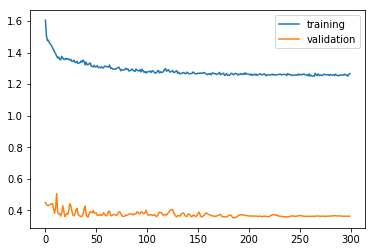

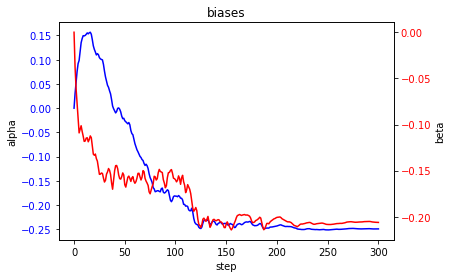

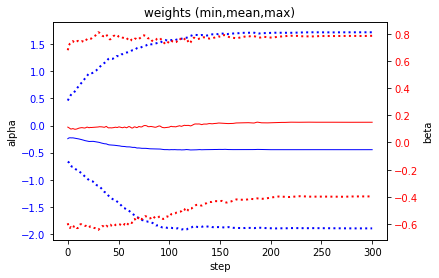

In [13]:
plt.plot(history.history['loss'],    label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()
plt.show()
weightwatcher.plot()

## Predict 

In [14]:
predicted = model.predict(x)
predicted[:,:,1]=predicted[:,:,1]+predicted[:,:,0]*0# lazy re-add of NAN-mask
print(predicted.shape)
print('mean alpha pred',np.nanmean(predicted[:,:,0]))
print('mean beta pred',np.nanmean(predicted[:,:,1]))

# Here you'd stop after transforming to dataframe and piping it back to some database
tr.padded_to_df(predicted,column_names=["alpha","beta"],dtypes=[float,float])


(1055, 608, 2)
mean alpha pred 3835.77306844
mean beta pred 0.750825622164


,id,t,alpha,beta
0,0,0,8.680714,0.453532
1,0,1,18.189529,0.530717
2,0,2,492.903648,0.292643
3,0,3,1407.219439,0.356919
4,0,4,9638.557612,0.365943
5,0,5,12363.559890,0.283980
6,0,6,8451.808775,0.289933
7,0,7,7912.770509,0.266031
8,0,8,8540.195248,0.257130
9,0,9,8339.929803,0.297771


## Scatter

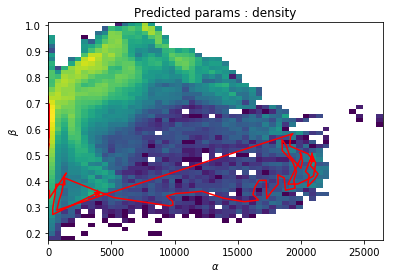

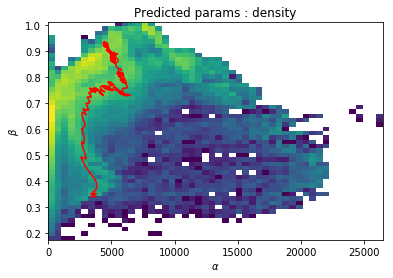

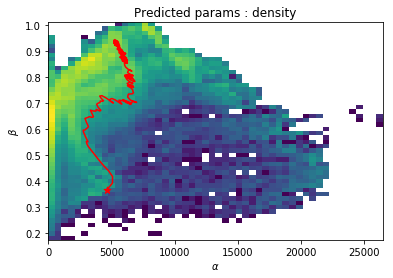

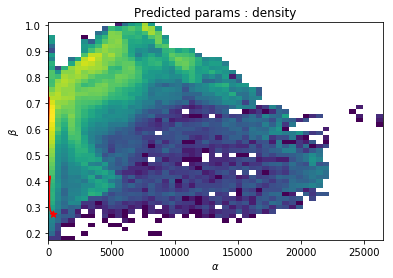

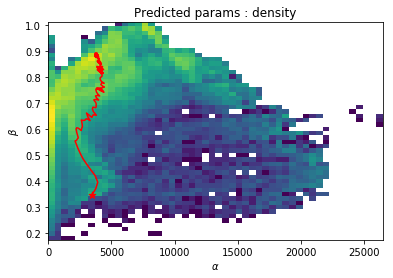

In [15]:
# Pick some random sequence
np.random.seed(12) # 9, 6,5,4 ok
random_selection =np.random.choice(predicted.shape[0], min([5,predicted.shape[0]]))
random_selection = np.sort(random_selection)

# Alpha and beta projections
alpha_flat = predicted[:,:,0][~np.isnan(predicted[:,:,0])].flatten()
beta_flat  = predicted[:,:,1][~np.isnan(predicted[:,:,0])].flatten()

## log-alpha typically makes more sense.

for batch_indx in random_selection:
    from matplotlib.colors import LogNorm
    counts, xedges, yedges, _ = plt.hist2d(alpha_flat, beta_flat, bins=50,norm=LogNorm())
    
    plt.plot(predicted[batch_indx,:,0],predicted[batch_indx,:,1],color='red')
    
    plt.scatter(predicted[batch_indx,0,0],predicted[batch_indx,0,1],
                marker = '*',
                s=50,
                color='red')
    
    plt.title('Predicted params : density')
    plt.xlim([alpha_flat.min(),alpha_flat.max()])
    plt.ylim([beta_flat.min(),beta_flat.max()])
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\beta$')
    plt.show()


## Individual sequences

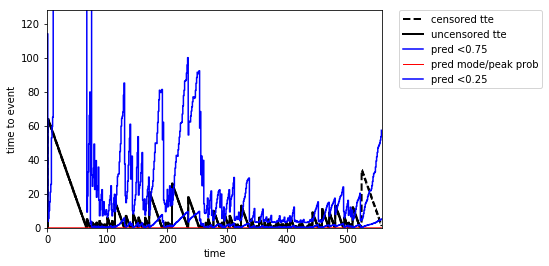

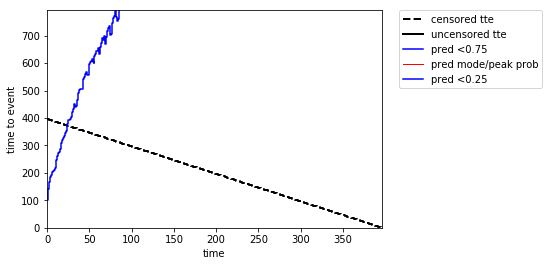

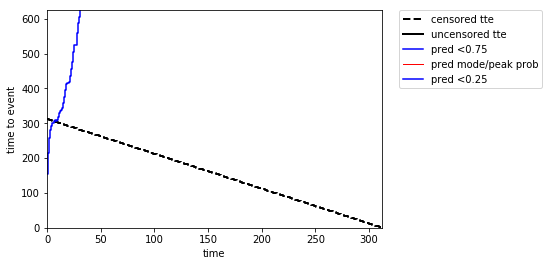

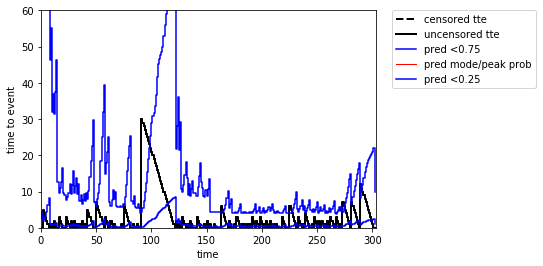

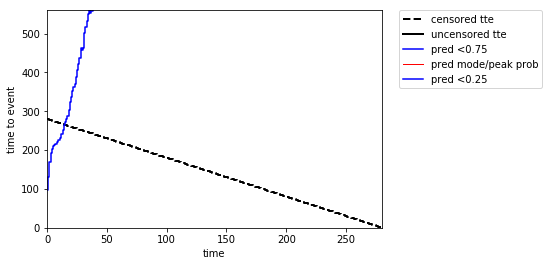

In [16]:
drawstyle = 'steps-post'
for batch_indx in random_selection:
    this_seq_len = seq_lengths[batch_indx]
    a = predicted[batch_indx,:this_seq_len,0]
    b = predicted[batch_indx,:this_seq_len,1]
    t = np.array(xrange(len(a)))
    x_this = x[batch_indx,:this_seq_len,:]

    this_tte = y[batch_indx,:this_seq_len,0]
    u = y[batch_indx,:this_seq_len,1]>0
    
    plt.plot(this_tte,label='censored tte',color='black',linestyle='dashed',linewidth=2,drawstyle=drawstyle)
    plt.plot(t[u],this_tte[u],label='uncensored tte',color='black',linestyle='solid',linewidth=2,drawstyle=drawstyle)
    
    plt.plot(weibull.quantiles(a,b,0.75),color='blue',label='pred <0.75',drawstyle=drawstyle)
    plt.plot(weibull.mode(a, b), color='red',linewidth=1,label='pred mode/peak prob',drawstyle=drawstyle)
#    plt.plot(weibull.mean(a, b), color='green',linewidth=1,label='pred mean',drawstyle='steps-post')
    plt.plot(weibull.quantiles(a,b,0.25),color='blue',label='pred <0.25',drawstyle=drawstyle)
    
    plt.xlim(0, this_seq_len)
    plt.ylim(0, min([2*this_tte.max(),2*a.max()]))
    plt.xlabel('time')
    plt.ylabel('time to event')
#     plt.title(authour_names[batch_indx])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()


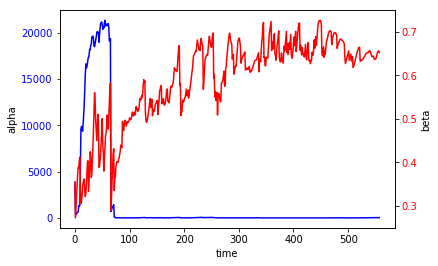

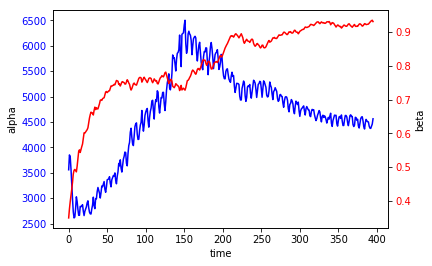

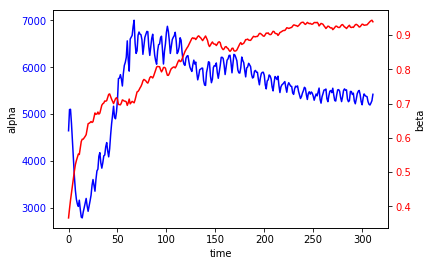

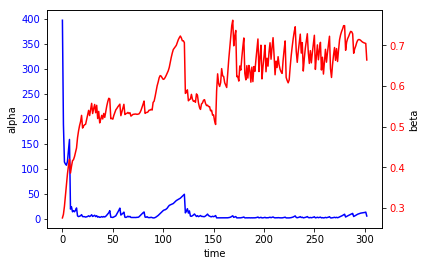

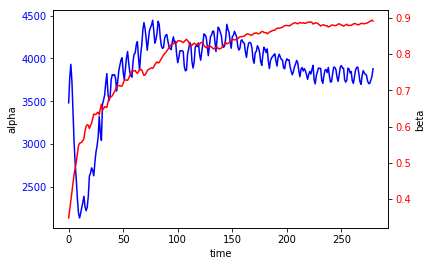

In [17]:
drawstyle = 'steps-post'
for batch_indx in random_selection:
    this_seq_len  = seq_lengths[batch_indx]
    a = predicted[batch_indx,:this_seq_len,0]
    b = predicted[batch_indx,:this_seq_len,1]
    t = np.array(xrange(len(a)))
    x_this = x[batch_indx,:this_seq_len,:]

    ##### Parameters
    # Create axes
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(t, a, color='b')
    ax1.set_xlabel('time')
    ax1.set_ylabel('alpha')

    ax2.plot(t, b, color='r')
    ax2.set_ylabel('beta')

    # Change color of each axis
    def color_y_axis(ax, color):
        """Color your axes."""
        for t in ax.get_yticklabels():
            t.set_color(color)
        return None
    color_y_axis(ax1, 'b')
    color_y_axis(ax2, 'r')
    plt.show()

# Density plot
Warning: Doesn't look very impressive when we have $\beta$ around $\leq 1$ since pdf is strictly decreasing (hence mode =0). 

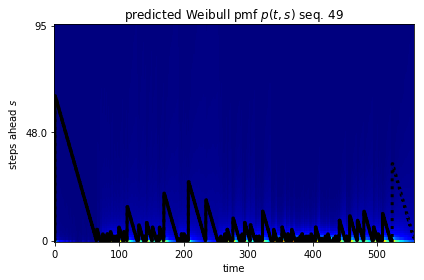

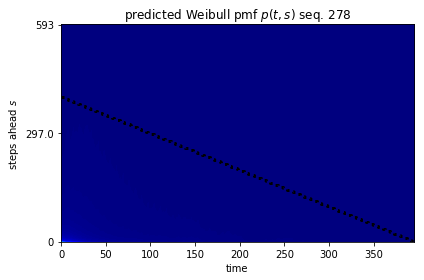

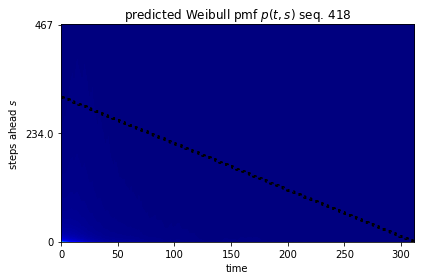

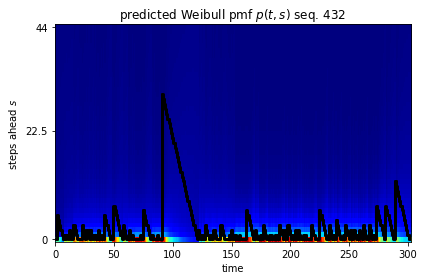

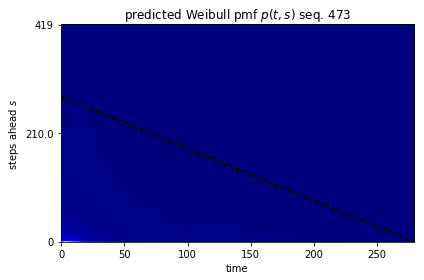

In [18]:
from wtte.plots.weibull_heatmap import weibull_heatmap
# np.random.seed(1)
for batch_indx in random_selection:
    this_seq_len = seq_lengths[batch_indx]
    if this_seq_len==0:
        next
    a = predicted[batch_indx,:this_seq_len,0]
    b = predicted[batch_indx,:this_seq_len,1]
    t = np.array(xrange(len(a)))
    x_this = x[batch_indx,:this_seq_len,:]

    this_tte = y[batch_indx,:this_seq_len,0]
    censoring_indicator = y[batch_indx,:this_seq_len,1]<1

    fig, ax = plt.subplots(1)

    weibull_heatmap(
        fig,ax,
        t,
        a,
        b,
        max_horizon = int(1.5*this_tte.max()),
        time_to_event=this_tte,
        true_time_to_event=None,
        censoring_indicator = censoring_indicator,
        title='predicted Weibull pmf $p(t,s)$ seq. '+str(batch_indx),
        lw=3.0,
        is_discrete=True,
        resolution=None,
        xax_nbins=10,
        yax_nbins=4 
    )
    plt.show()

# Aggregate view

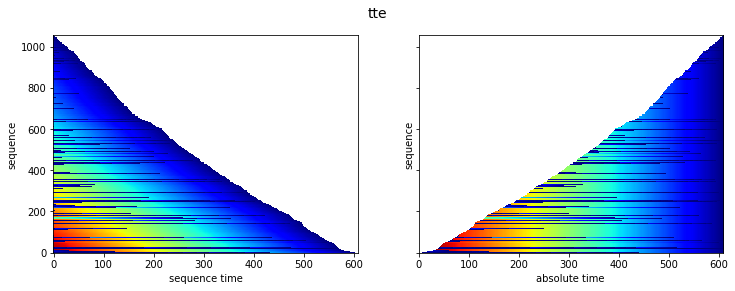

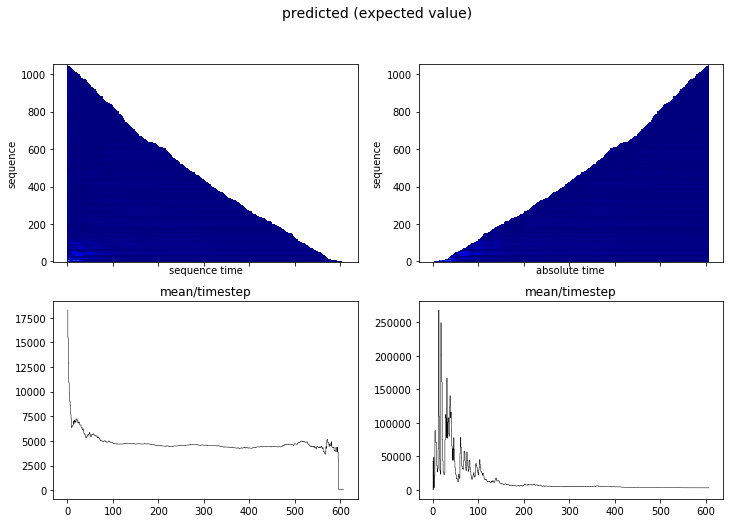

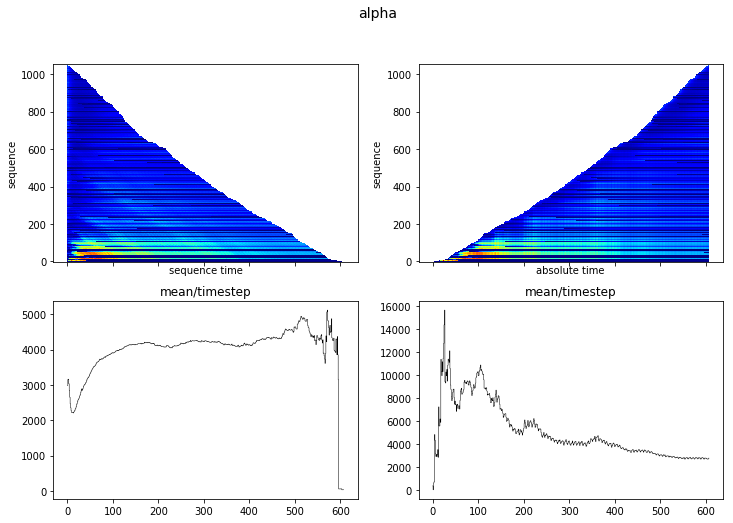

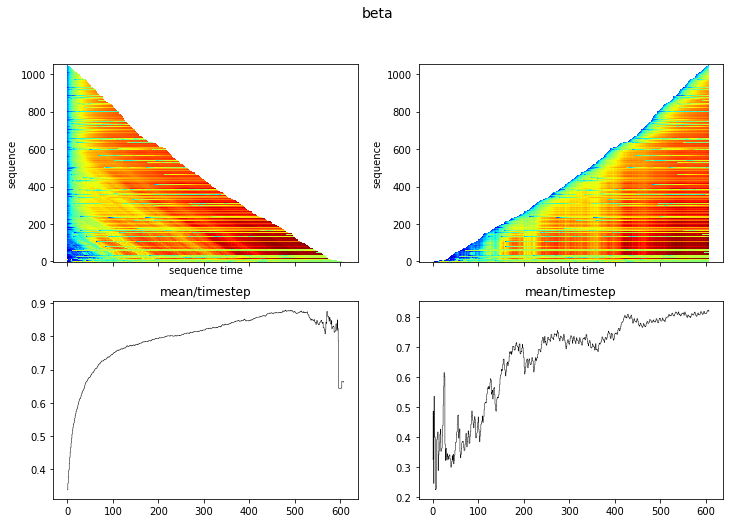

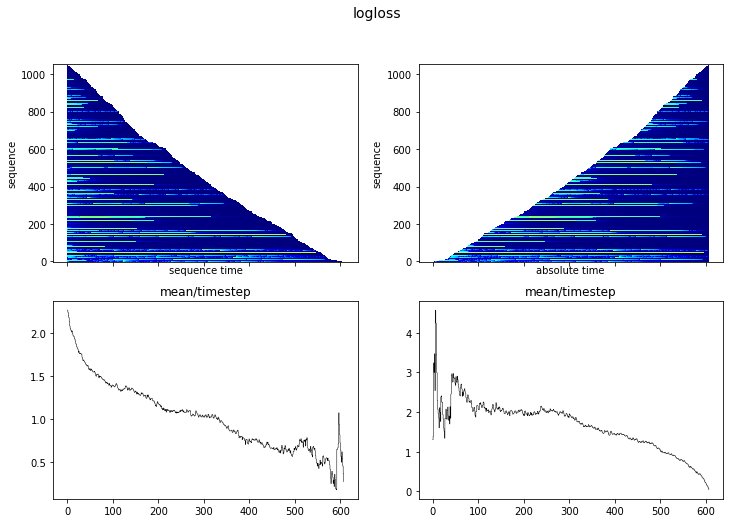

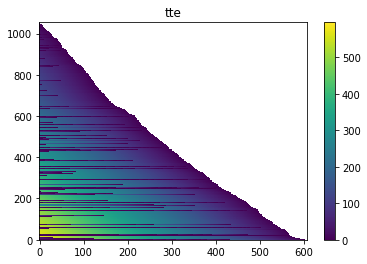

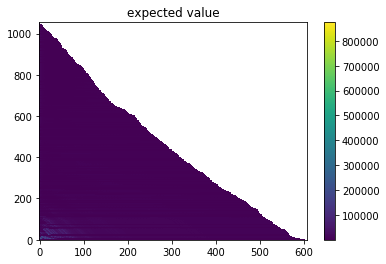

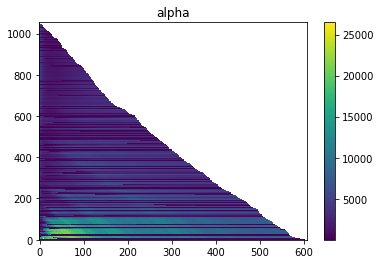

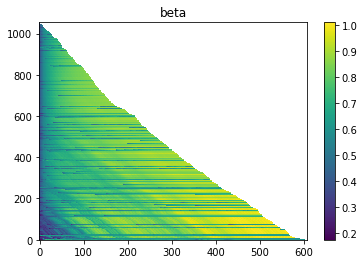

In [19]:
fig,ax = timeline_plot(y[:,:,0],"tte",plot=False)
plt.show()

padded = weibull.mean(a=predicted[:,:,0],b=predicted[:,:,1])
timeline_aggregate_plot(padded,"predicted (expected value)")
plt.show()

timeline_aggregate_plot(predicted[:,:,0],"alpha")
plt.show()

timeline_aggregate_plot(predicted[:,:,1],"beta")
plt.show()

padded = -weibull.discrete_loglik(a=predicted[:,:,0],b=predicted[:,:,1],t=y[:,:,0],u=y[:,:,1],equality=False)
timeline_aggregate_plot(padded,"logloss")
plt.show()

plt.imshow(y[:,:,0],aspect='auto',interpolation="none",origin='lower')  
plt.title('tte')
plt.colorbar()
plt.show()

padded = weibull.mean(a=predicted[:,:,0],b=predicted[:,:,1])
plt.imshow(padded,aspect='auto',interpolation="none",origin='lower')  
plt.title('expected value')
plt.colorbar()
plt.show()

plt.imshow(predicted[:,:,0],aspect='auto',interpolation="none",origin='lower')  
plt.title('alpha')
plt.colorbar()
plt.show()
plt.imshow(predicted[:,:,1],aspect='auto',interpolation="none",origin='lower')  
plt.title('beta')
plt.colorbar()
plt.show()

# Calibration

For the uncensored points we assume F(Y) to be uniform. 

Deviations means we have problem of calibration (which we have obviously below.)

*Note* this is dependent on sample_weights set to 1 or 0

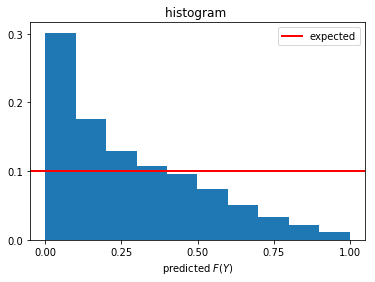

In [20]:
n_bins = 10
cmf = weibull.cmf(t=y[:,:,0],a=predicted[:,:,0],b=predicted[:,:,1])

cmf = cmf[(~np.isnan(y[:,:,1]))*(y[:,:,1]==1) ]
cmf = cmf[~np.isnan(cmf)]
plt.hist(cmf.flatten(),n_bins,weights = np.ones_like(cmf.flatten())/float(len(cmf.flatten())))
plt.xlabel(r'predicted $F(Y)$')
plt.title('histogram ')
plt.axhline(1.0/n_bins,lw=2,c='red',label='expected')
plt.locator_params(axis='both',nbins=5)
plt.legend()
plt.show()
del cmf

# Evaluated like a sliding box 

Given that we seldom have the truth due to censored data we partly need to rely on the log-loss. Calibration gives us a hint too. A more intuitive feel is to see what the AUC would have been if it was a fixed-window. See 'sliding box'
see https://ragulpr.github.io/2016/12/22/WTTE-RNN-Hackless-churn-modeling/#sliding-box-model

*Note* this is dependent on sample_weights set to 1 or 0

auc:  0.838549042414  sliding box  0
auc:  0.824028712771  sliding box  10
auc:  0.813233136922  sliding box  20
auc:  0.810174593668  sliding box  30
auc:  0.812016438211  sliding box  40
auc:  0.815024120837  sliding box  50
auc:  0.818087680407  sliding box  60
auc:  0.821709603934  sliding box  70
auc:  0.826475990017  sliding box  80
auc:  0.827971484218  sliding box  90
auc:  0.830100331738  sliding box  100
auc:  0.831221744152  sliding box  110
auc:  0.831692432984  sliding box  120
auc:  0.83249597221  sliding box  130
auc:  0.834763060314  sliding box  140
auc:  0.837148497972  sliding box  150
auc:  0.841740540188  sliding box  160
auc:  0.842194139484  sliding box  170
auc:  0.842178176691  sliding box  180
auc:  0.841795560876  sliding box  190
auc:  0.84081425084  sliding box  200
auc:  0.840579420542  sliding box  210
auc:  0.840616944497  sliding box  220
auc:  0.840127004966  sliding box  230
auc:  0.839485414961  sliding box  240
auc:  0.839684613587  sliding box  250

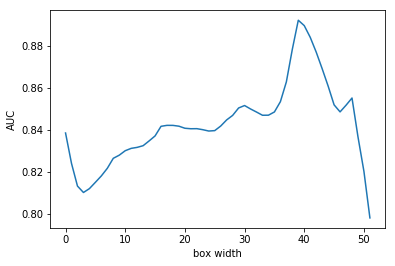

In [22]:
from sklearn import metrics
aucs =[]
# compare score to sliding box up to some width, up to last decile
max_box_width = np.sort(seq_lengths)[-len(seq_lengths)//10]

for box_width in xrange(max_box_width):
    if (box_width%10)==0:
        # select only unmasked and comparable datapoints.

        m = ~np.isnan(y[:,:,1])
        # uncensored or within box_width of boundary 
        m[m] = (y[:,:,1][m]==1)|(box_width<y[:,:,1][m]) 

        actual = y[:,:,0][m].flatten()<=box_width
        pred   = weibull.cmf(a=predicted[:,:,0],b=predicted[:,:,1],t=box_width)[m].flatten()

        fpr,tpr,thresholds = metrics.roc_curve(actual,pred)
        auc = metrics.auc(fpr,tpr)
        print('auc: ',auc,' sliding box ',box_width)
        aucs.append(auc)
plt.plot(aucs)
plt.ylabel('AUC')
plt.xlabel('box width')


# Esoteric plots

## Animate predicted churn
Those with alpha higher than at the their last step is red. Red stream of blood going to the right corner are predicted churners

In [ ]:
#### Walk through the timeline and look at the embedding.
# by day
padded = tr.right_pad_to_left_pad(predicted)
events_tmp = tr.right_pad_to_left_pad(events)
# by day since signup
# padded = np.copy(predicted)                            
# events_tmp = np.copy(events)
    
fig, ax = plt.subplots(ncols=2, sharey=False,figsize=(12,4))
cmap = None

ax[1].imshow(events_tmp,interpolation='none', aspect='auto',cmap='Greys',origin='lower')
ax[1].set_title('events');
ax[1].set_ylabel('sequence');
ax[1].set_xlabel('timestep');
ln= ax[1].axvline(x=0,c="red",linewidth=.5,zorder=10)


xlims = [np.nanmin(padded[:,:,0]),np.nanmax(padded[:,:,0])]
ylims = [np.nanmin(padded[:,:,1]),np.nanmax(padded[:,:,1])]
seq_timestep = np.cumsum(np.isnan(padded[:,:,0]),1)

for timestep in xrange(0,predicted.shape[1]):        
    ax[0].cla()

#     from matplotlib.colors import LogNorm
#     m = ~np.isnan(padded[:,timestep,0])
#     ax[0].hist2d(np.log(padded[m,timestep,0]), padded[m,timestep,1], bins=50,norm=LogNorm())
        
    if timestep == 0:
        colors = 'blue'
        this_pred = padded[:,0,:]
    else:
        m = ~np.isnan(padded[:,timestep,0])
        this_pred = padded[m,timestep,:]
    
        alpha_larger = padded[m,timestep-1,0]<padded[m,timestep,0]
        
        # blue : first step
        # Black : same or lower alpha
        # Red : higher alpha
        colors = np.repeat('black',len(alpha_larger))
        colors[alpha_larger] = 'red'
        colors[np.isnan(padded[m,timestep-1,0])] = 'blue'
    
    ax[0].scatter(this_pred[:,0],
                  this_pred[:,1],
                color = colors,
                s=1,
                linewidths=0
               )
    
    ax[0].set_xlim(xlims)
    ax[0].set_ylim(ylims)
    ax[0].set_xscale("log", nonposx='clip')
    
    ax[0].set_title('predicted');
    ax[0].set_xlabel(r'$log(\alpha)$')
    ax[0].set_ylabel(r'$\beta$')

    ln.remove()
    ln= ax[1].axvline(x=timestep,c="red",linewidth=.5,zorder=10)

#     fig_name = './figures/'+format(timestep,'05d')
#     fig.savefig(fig_name,bbox_inches='tight',transparent=False,dpi=100)
#     plt.gcf()
    display.display(plt.gcf())
    display.clear_output(wait=True)

del seq_timestep,xlims,ylims,events_tmp

# Conclusions
- 20% of the observations are censored, this is alot causing some instability.
- The network becomes fairly good at recognizing death (hence shifting the distribution up when its apparent they'r not coming back). This is partly a form of artifact learning, partly a good thing.

## Remedies
- I have tested some things based on Inverse Probability Of Censoring that works to keep the distribution at bay like weighting censored observations according to the probability that they'd be censored in the first place (estimated using by overfitting an identical binary network).
- Long sequences have more timesteps so more influence on loss if we dont apply weights
- Clipping. Duct-tape solution that only partly works and may risk 
- Penalizing high predictions for censored datapoints. I.e add a F(Y) penalty whenever F(Y)>some threshold and Y>some threshold
- Don't use remedies. The fact that some observations have expected values going to infinity may be sought.
